In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from tqdm import tqdm
import pandas as pd

np.random.seed(1)

# Introduction

# Basic setting

In [0]:
path = Path('/content/gdrive/My Drive/colab/data/db/')

labels = pd.read_csv(path/'labels.csv')

device = torch.device('cuda')

categories = ['clothing_pattern', 'major_color', 'sleeve_length', 'neckline_shape', 'clothing_category', 'multiple_layers']
labels.loc[labels['label'].isna(), 'label'] = ''

assert not (any(labels['url'].isna()) or any(labels['label'].isna()) or any(labels['test'].isna()) )

In [0]:
#!ls -l 'data/all'

total 2576
drwxr-xr-x 2 root root  282624 May 15 15:56 test
drwxr-xr-x 2 root root 2347008 May 15 15:56 train


In [0]:
bs = 32
if crop_imgs:
    path = 'data/cropped'
else:
    path = 'data/all'
data = (ImageList.from_df(labels[~labels['test']], path, folder='train')
        .split_from_df(col='valid') 
        .label_from_df(label_delim=';')  
        .transform(get_transforms(), size=299)  
        .databunch(bs=bs, device=device).normalize(imagenet_stats))

print(f'Number of classes: {data.c}, training examples: {len(data.train_ds)}')

Number of classes: 40, training examples: 21687


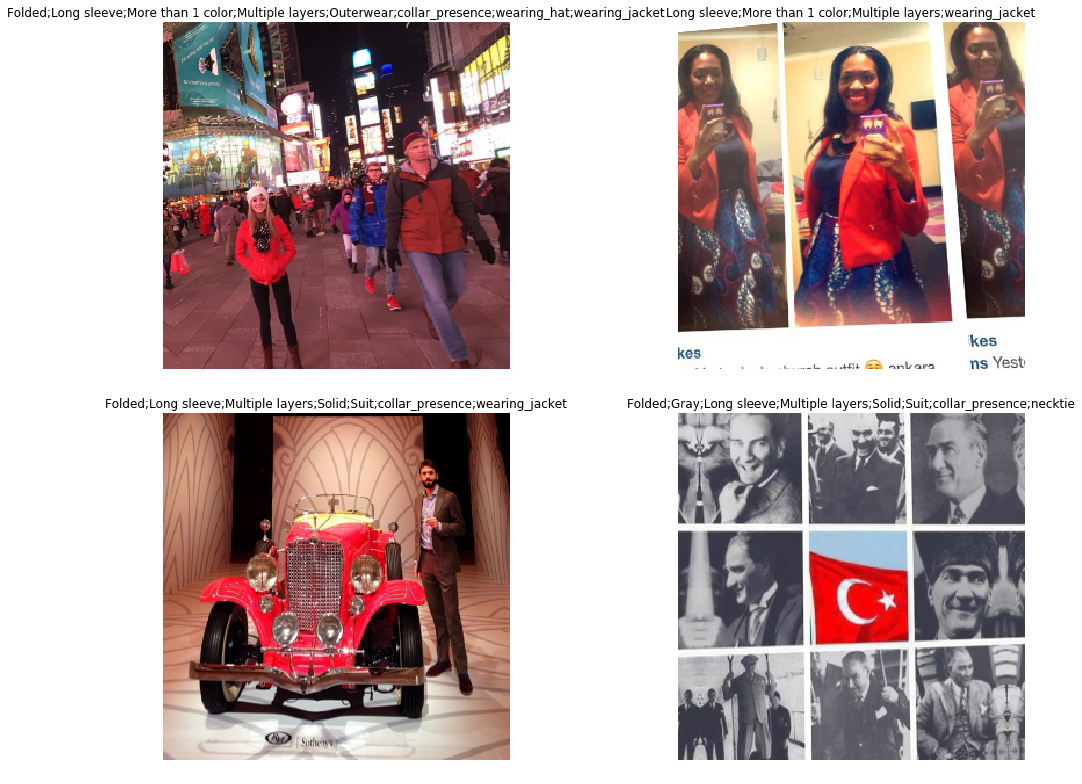

In [0]:
data.show_batch(rows=2, figsize=(15,11))

Reweights

In [0]:
def get_cats(df, col):
    '''
    Returns unique (non-NA) values for column `col` in dataframe `df`
    '''
    na_flag = df[col].isna()
    return df.loc[~na_flag, col].unique()
    
def get_cat_idxs(cats, data_classes):
    '''
    Returns indices `data_classes` that appear in `cats`.
    '''    
    cats, data_classes = np.array(cats), np.array(data_classes)
    assert len(cats.shape) == 1 and len(data_classes.shape) == 1
    return np.where((data_classes[None, :] == cats[:, None]))[1]

def get_y_totals(data):
    '''Counts the label occurence for training data in databunch `data`. (Sums up y values)'''    
    with torch.no_grad():
        sums = [yb.sum(dim=0) for _, yb in tqdm(data.train_dl, position=0)]
        return torch.stack(sums).sum(dim=0)

In [0]:
y_totals = get_y_totals(data)
y_totals

100%|██████████| 677/677 [11:04<00:00,  1.36it/s]


tensor([ 5459.,  1984.,   335.,    29.,  2128.,   751.,  6754.,  3205.,  1116.,
          452., 11234.,  2071.,  7419.,  2907., 13297.,   136.,  3827.,   543.,
          451.,   146.,   953.,  8234.,  3868.,  6012., 13343.,   201.,   915.,
          976.,   725.,  3860.,  1117.,  1725.,  3723.,   393.,  6102.,   707.,
         2829.,  1874.,  5972.,  1212.], device='cuda:0')

In [0]:
def cat_weight(y_totals, cat_col, labels, data_classes):
    '''Gets updated weights for a label category, based on relative frequency in that category.'''
    idxs = get_cat_idxs(get_cats(labels, cat_col), data_classes)
    sub = y_totals[idxs]
    c = 1/(1/sub).sum()
    new_weights = c/sub
    return {idx:new_weights[i] for i, idx in enumerate(idxs)}

def get_cat_weights(y_totals, categories, labels, data_classes):
    '''Gets updated weights for all label categories.'''
    cat_weights = {}
    for cat_col in categories: cat_weights.update(cat_weight(y_totals, cat_col, labels, data_classes))
    return cat_weights

def get_binary_weight(x, total): return (total-x) / total

def get_new_weights(y_totals, categories, labels, data_classes, num_samples):
    '''Returns updated weights based on label frequencies.'''
    assert not any(y_totals<=0) and len(y_totals.shape) == 1
    
    cat_weights = get_cat_weights(y_totals, categories, labels, data_classes)
    
    new_weights = []
    for idx in range(y_totals.shape[0]):
        new_weights.append(cat_weights[idx] if idx in cat_weights.keys() else get_binary_weight(y_totals[idx], num_samples))
        
    return torch.tensor(new_weights, dtype=torch.float32)

In [0]:
new_weights = get_new_weights(y_totals, categories, labels, data.classes, len(data.train_ds)).to(device)
new_weights
print('Smallest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[:5]])
print('\nLargest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[-5:]])

Smallest Weights (label, y_total, new_weight):
[('Black', tensor(5459., device='cuda:0'), tensor(0.0030, device='cuda:0')), ('White', tensor(3723., device='cuda:0'), tensor(0.0044, device='cuda:0')), ('Solid', tensor(13343., device='cuda:0'), tensor(0.0075, device='cuda:0')), ('More than 1 color', tensor(2071., device='cuda:0'), tensor(0.0078, device='cuda:0')), ('Blue', tensor(1984., device='cuda:0'), tensor(0.0082, device='cuda:0'))]

Largest Weights (label, y_total, new_weight):
[('wearing_jacket', tensor(5972., device='cuda:0'), tensor(0.7246, device='cuda:0')), ('wearing_glasses', tensor(2829., device='cuda:0'), tensor(0.8696, device='cuda:0')), ('wearing_hat', tensor(1874., device='cuda:0'), tensor(0.9136, device='cuda:0')), ('wearing_scarf', tensor(1212., device='cuda:0'), tensor(0.9441, device='cuda:0')), ('necktie', tensor(707., device='cuda:0'), tensor(0.9674, device='cuda:0'))]


# Fit Model

First Model

In [0]:
ARCH = models.resnet34
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = create_cnn(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


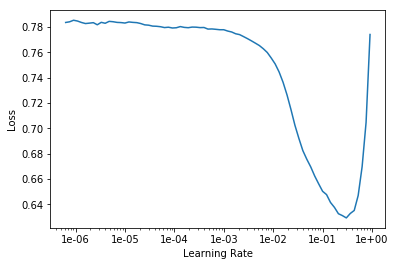

In [0]:
learn.lr_find()
learn.recorder.plot()

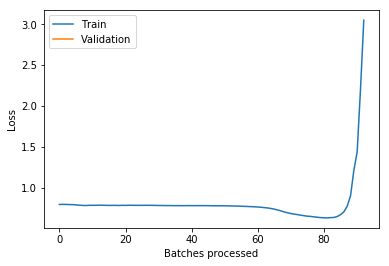

In [0]:
learn.recorder.plot_losses()

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.fit_one_cycle(5, 1e-2)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.277064,0.274475,0.886273,12:29
1,0.272099,0.272102,0.889345,12:31
2,0.259831,0.266382,0.888432,12:32
3,0.250326,0.240619,0.900830,12:37
4,0.238872,0.236514,0.902592,12:35


In [0]:
learn.save('res_streetstyle_custom_loss_rn34_01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


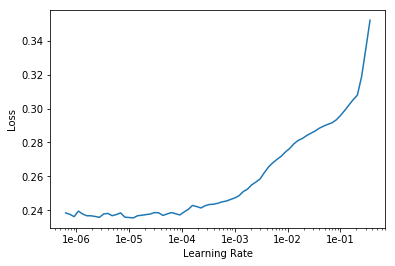

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_custom_loss_rn34_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.239665,0.235819,0.902519,12:48
1,0.236413,0.233101,0.903745,12:45
2,0.234517,0.231696,0.904825,12:45
3,0.233389,0.230358,0.905083,12:44
4,0.228497,0.229642,0.905387,12:51


In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_custom_loss_rn34_02')
learn.save('res_streetstyle_custom_loss_rn34_02')

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load('res_streetstyle_custom_loss_rn34_02')
print('loaded')

loaded


Prediction

In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/colab')
from plotting_fns import *

In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()
len(val_labs.index)

2710

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')

Accuracy for clothing_pattern is 0.8050448909790509
Accuracy for major_color is 0.592814371257485
Accuracy for sleeve_length is 0.7839335180055401
Accuracy for neckline_shape is 0.7058543550690147
Accuracy for clothing_category is 0.6086133459536205
Accuracy for multiple_layers is 0.8012279355333844


Confusion matrix, without normalization


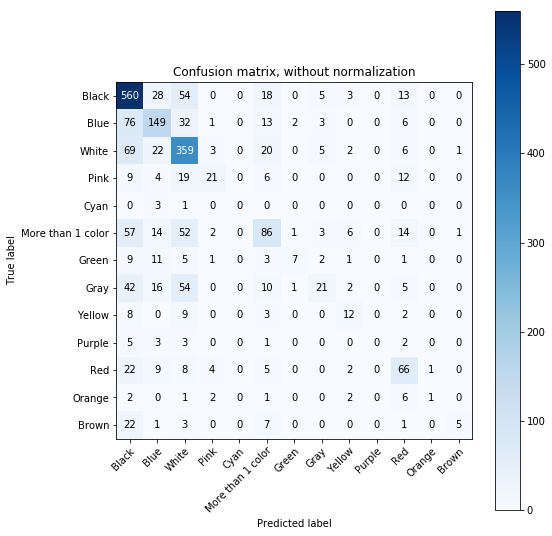

In [0]:
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()